## Task 3

1. Apply the *logistic regression* method using the functions in the notebook 
    "Logistic Regression as a Neural Network – BP alg.ipynb"
    to predict the *biological response* of a molecule.
    
    Use 75% of the dataset to train the model, and the rest of the data to estimate its accuracy.

2. Modify *optimize()* function to implement the *stochastic gradient descent (SGD)* method. 
    Apply it to solve the problem from p.1.

3. For two modifications of *gradient descent* (pp. 1 and 2), 
    plot the *learning curves* (dependence of the value of *the loss function* on the iteration number), 
    apply models with different values of *the learning rate* (at least 5 different learning rates). 
    How does it affect the accuracy of the model?

4. Implement the *Adam optimization* method using the numpy library 
    and compare the accuracy of the model fitted with it with the models 
    trained by the classic *GD* and *SGD* algorithms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [2]:
# sigmoid
def sigmoid(z):
    s = 1. / (1. + np.exp(-z))
    return s

# initialize_with_zeros
def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0.
    return w, b

# propagate
def propagate(w, b, x_data, y_labels):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = x_data.shape[1]
    #print('number of objects = ',len(X))
    
    # FORWARD PROPAGATION (FROM X TO COST)
    activation = sigmoid(np.dot(w.T, x_data) + b)  # compute activation
    cost = -(1. / m) * np.sum(
        y_labels * np.log(activation) + (1 - y_labels) * np.log(1 - activation),
        axis=1
    )  # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1. / m) * np.dot(x_data, (activation - y_labels).T)
    db = (1. / m) * np.sum(activation - y_labels, axis=1)

    grads = {"dw": dw, "db": db}
    
    return grads, cost    

### Logistic regression method

In [3]:
# optimize
def optimize(w, b, x_data, y_labels, num_iterations, learning_rate, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    dw, db = None, None
    
    for i in range(num_iterations):  
        # Cost and gradient calculation 
        grads, cost = propagate(w, b, x_data, y_labels)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w -= learning_rate * dw
        b -= learning_rate * db
        
        # Record the costs
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
    
    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}
    
    return params, grads, costs

# predict
def predict(w, b, x_data):
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    """
    
    m = x_data.shape[1]
    y_prediction = np.zeros((1, m))
    w = w.reshape(x_data.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities 
    a_vec = sigmoid(np.dot(w.T, x_data) + b)
    
    for i in range(a_vec.shape[1]):    
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if a_vec[0, i] <= 0.5:
            y_prediction[0][i] = 0
        else:
            y_prediction[0][i] = 1
    
    return y_prediction

# model
def model(x_train, y_train, x_test, y_test, num_iterations = 2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function we've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array 
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array 
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    x_train = x_train.T
    x_test = x_test.T
    
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(x_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, x_train, y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    y_prediction_train = predict(w, b, x_train)
    y_prediction_test = predict(w, b, x_test)

    # Print train/test Errors
    print("\ttrain accuracy: {:.1f} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("\ttest accuracy: {:.1f} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))

    d = {
        "costs": costs,
        "Y_prediction_train" : y_prediction_train,
        "Y_prediction_test": y_prediction_test,  
        "w" : w, 
        "b" : b,
        "learning_rate" : learning_rate,
        "num_iterations": num_iterations
    }
    
    return d

### Stochastic gradient descent method

In [4]:
# optimize SGD
def optimize_sgd(w, b, x_data, y_labels, num_iterations, learning_rate, batch_size=5, print_cost=False):
    """
    batch_size -- size of the batch of samples
    """
    costs = []
    dw, db = None, None
    batch_size = min(x_data.shape[1], batch_size)
   
    for i in range(num_iterations):
        batch_idx = np.random.choice(x_data.shape[1], batch_size ,replace=False)
        sub_x = x_data[:, batch_idx]
        sub_y = y_labels[batch_idx]
        
        # Cost and gradient calculation 
        grads, cost = propagate(w, b, sub_x, sub_y)
        
        # For loss result
        _, cost_j = propagate(w, b, x_data, y_labels)
        
        dw, db = grads["dw"], grads["db"]
        
        w -= learning_rate * dw
        b -= learning_rate * db
        
        costs.append(cost_j)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost_j))
    
    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}
    
    return params, grads, costs

# model SGD
def model_sgd(x_train, y_train, x_test, y_test, num_iterations=1000, learning_rate=0.5, batch_size=5, print_cost=False):
    x_train = x_train.T
    x_test = x_test.T
 
    w, b = initialize_with_zeros(x_train.shape[0])

    params, grads, costs = optimize_sgd(w, b, x_train, y_train, num_iterations, learning_rate, batch_size, print_cost)
    
    w, b = params["w"], params["b"]
    
    y_prediction_test = predict(w, b, x_test)
    y_prediction_train = predict(w, b, x_train)

    print("\ttrain accuracy: {:.1f} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("\ttest accuracy: {:.1f} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))

    d = {
        "costs": costs,
        "Y_prediction_test": y_prediction_test, 
        "Y_prediction_train" : y_prediction_train, 
        "w" : w, 
        "b" : b,
        "learning_rate" : learning_rate,
        "num_iterations": num_iterations
    }
    
    return d

### Adam optimization method

In [5]:
# optimize Adam
def optimize_adam(w, b, x_data, y_labels, num_iterations, learning_rate, 
                  b_1=0.3, b_2=0.999, eps=1e-8, batch_size=5, print_cost=False):
    """
    b_1 and b_2 -- learning parameters of Adam optimizer
    eps -- threshold.
    """
    costs = []
    
    #Initialization of the parameters for Adam optimizer
    v, s = 0, 0
    dw, db = None, None
    batch_size = min(x_data.shape[1], batch_size)

    for i in range(num_iterations):
        #batch selection
        batch_ids = np.random.choice(x_data.shape[1], batch_size ,replace=False)
        sub_x = x_data[:, batch_ids]
        sub_y = y_labels[batch_ids]
        
        grads, cost = propagate(w, b, sub_x, sub_y)
        
        # For loss result
        _, cost_j = propagate(w, b, x_data, y_labels)
        
        dw, db = grads["dw"], grads["db"]
        full_grad = np.concatenate((dw, db.reshape(1, 1)))
        
        v = b_1 * v + (1 - b_1) * full_grad
        s = b_2 * s + (1 - b_2) * np.sum(full_grad**2)
        
        w -= learning_rate / (np.sqrt(s) + eps) * v[:-1]
        b -= learning_rate / (np.sqrt(s) + eps) * v[1]
        
        costs.append(cost_j)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost_j))
    
    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}
    
    return params, grads, costs

# model Adam
def model_adam(x_train, y_train, x_test, y_test, num_iterations=1000, learning_rate=0.5, 
               b_1=0.9, b_2=0.999, eps=1e-8, batch_size=5, print_cost=False):
    x_train = x_train.T
    x_test = x_test.T
    
    w, b = initialize_with_zeros(x_train.shape[0])

    params, grads, costs = optimize_adam(w, b, x_train, y_train, num_iterations, learning_rate, 
                                         b_1, b_2, eps, batch_size, print_cost)
    
    w, b = params["w"], params["b"]
    
    y_prediction_test = predict(w, b, x_test)
    y_prediction_train = predict(w, b, x_train)

    print("\ttrain accuracy: {:.1f} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("\ttest accuracy: {:.1f} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))

    d = {
        "costs": costs,
        "Y_prediction_test": y_prediction_test, 
        "Y_prediction_train" : y_prediction_train, 
        "w" : w, 
        "b" : b,
        "learning_rate" : learning_rate,
        "num_iterations": num_iterations
    }
    
    return d

In [6]:
df = pd.read_csv("../lab_01/bioresponse.csv")
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [7]:
x_dataset = df.drop("Activity", axis=1).to_numpy()
y_dataset = df["Activity"].to_numpy()

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.25, random_state=77)

In [9]:
learn_rate_list = [0.01, 0.05, 0.1, 0.25, 0.5]
k = 3000

gd_results, sgd_results, adam_results = list(), list(), list()

#calculation of the results
for learn_r in learn_rate_list:
    print("Logistic regression, learn rate = {lr}".format(lr=learn_r))
    gd_results.append(model(x_train, y_train, x_test, y_test, num_iterations=k, learning_rate=learn_r))
    print("SGD, learn rate = {lr}".format(lr=learn_r))
    sgd_results.append(model_sgd(x_train, y_train, x_test, y_test, num_iterations=k, learning_rate=learn_r))
    print("Adam, learn rate = {lr}".format(lr=learn_r))
    adam_results.append(model_adam(x_train, y_train, x_test, y_test, num_iterations=k, learning_rate=learn_r))
    
all_results = [gd_results, sgd_results, adam_results]

Logistic regression, learn rate = 0.01
	train accuracy: 79.7 %
	test accuracy: 76.7 %
SGD, learn rate = 0.01
	train accuracy: 78.1 %
	test accuracy: 75.9 %
Adam, learn rate = 0.01
	train accuracy: 78.3 %
	test accuracy: 75.8 %
Logistic regression, learn rate = 0.05
	train accuracy: 82.9 %
	test accuracy: 77.6 %
SGD, learn rate = 0.05
	train accuracy: 78.3 %
	test accuracy: 73.2 %
Adam, learn rate = 0.05
	train accuracy: 81.0 %
	test accuracy: 76.0 %
Logistic regression, learn rate = 0.1
	train accuracy: 84.0 %
	test accuracy: 76.1 %
SGD, learn rate = 0.1
	train accuracy: 76.9 %
	test accuracy: 72.3 %
Adam, learn rate = 0.1
	train accuracy: 80.4 %
	test accuracy: 74.4 %
Logistic regression, learn rate = 0.25
	train accuracy: 86.0 %
	test accuracy: 75.3 %
SGD, learn rate = 0.25
	train accuracy: 77.7 %
	test accuracy: 71.3 %
Adam, learn rate = 0.25
	train accuracy: 81.3 %
	test accuracy: 74.6 %
Logistic regression, learn rate = 0.5
	train accuracy: 84.8 %
	test accuracy: 75.1 %
SGD, learn

c:\users\sultan\documents\work\master_1\ml_itmo\venv\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
c:\users\sultan\documents\work\master_1\ml_itmo\venv\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply


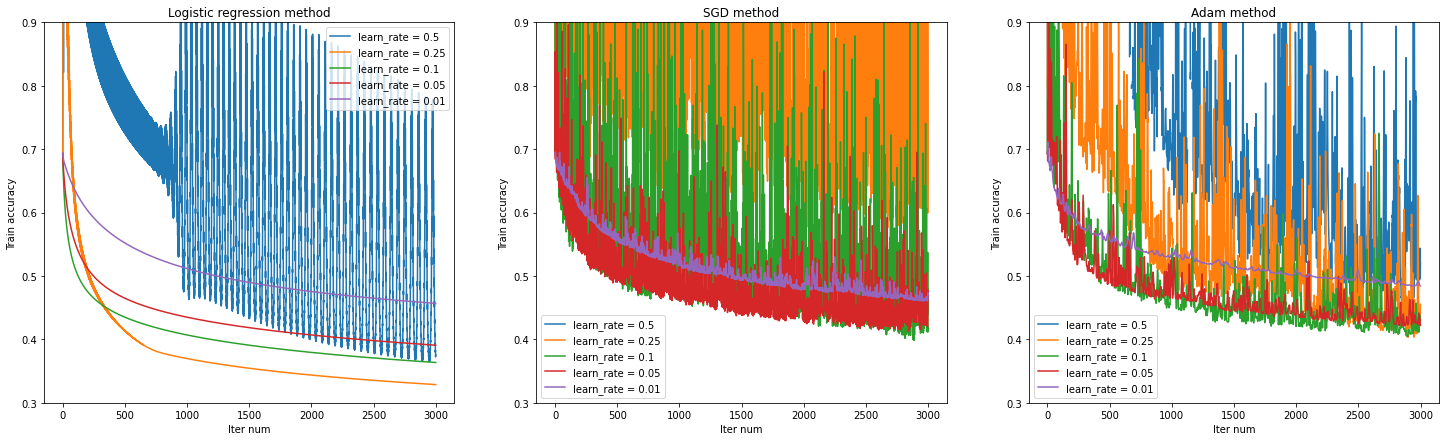

In [10]:
title_names = ["Logistic regression method", 'SGD method', 'Adam method']
fig, axs = plt.subplots(1, 3, figsize=(25, 7))

for i in range(3):
    for j in range(len(learn_rate_list) - 1, -1, -1):
        axs[i].plot(all_results[i][j]['costs'][::], label=f"learn_rate = {learn_rate_list[j]}")
    
    axs[i].set_title(title_names[i])
    axs[i].set_xlabel("Iter num")
    axs[i].set_ylabel("Train accuracy")
    axs[i].set_ylim([0.3, 0.9])
    axs[i].legend()

The graphs of the three methods differ greatly in the smoothness of the curves.  
*Linear regression* has the smoothest curves, because the descent goes in all directions.  
*SGD* has the largest spread, because due to the random selection of the batch, 
    the result of the loss function can vary greatly. But this approach allows you to find the minimum faster.  
To increase the speed of finding the minimum and reduce the spread of losses, you can use the *Adam method*.

In [11]:
accuracy_results = np.zeros((3, len(learn_rate_list)))

for i in range(3):
    for j in range(len(learn_rate_list)):
        accuracy_results[i, j] = accuracy_score(y_test, all_results[i][j]["Y_prediction_test"][0])
lr_name = [f"lr={lr}" for lr in learn_rate_list]        
accuracy_table = pd.DataFrame(data=accuracy_results, index=['Logistic regression', 'SGD', 'Adam'], columns=lr_name)
print('\nAccuracy results\n')
accuracy_table.round(3)


Accuracy results



,lr=0.01,lr=0.05,lr=0.1,lr=0.25,lr=0.5
Logistic regression,0.767,0.776,0.761,0.753,0.751
SGD,0.759,0.732,0.723,0.713,0.726
Adam,0.758,0.760,0.744,0.746,0.729


Based on the provided data, logistic regression provides better accuracy, 
    but with an increase in volume, this method will not be used due to the execution time.   
In this case, the Adam Method shows an accuracy higher than SGD.